# Rolling Planning mit Tardiness (Max)

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60*15 # 15 min

## Generierung des Datensatzes für 12 Tage (Ankunft)

In [3]:
day_count = 12

In [4]:
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J0,9,49,1440,1109.0
1,J1,5,130,1440,1104.0
2,J2,3,151,1440,1437.0
3,J3,4,226,1440,998.0
4,J4,6,386,1440,1203.0
...,...,...,...,...,...
15,J15,5,1142,1440,2116.0
16,J16,6,1254,1440,2071.0
17,J17,7,1285,1440,2343.0
18,J18,8,1397,1440,2569.0


## Params

In [5]:
# fix
day_length = 1440

In [6]:
# init
day_numb = 0

day_start = 0
day_end = 0

# Initialisierung (Tag 1)

In [7]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [8]:
# I)
df_jssp_curr, df_times_curr = process_filter.jobs_by_ready_time(df_jobs_times, df_jssp, ready_time = day_start)
df_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J0,9,49,1440,1109.0
1,J1,5,130,1440,1104.0
2,J2,3,151,1440,1437.0
3,J3,4,226,1440,998.0
4,J4,6,386,1440,1203.0
...,...,...,...,...,...
15,J15,5,1142,1440,2116.0
16,J16,6,1254,1440,2071.0
17,J17,7,1285,1440,2343.0
18,J18,8,1397,1440,2569.0


### Scheduling

In [9]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(df_jssp_curr, df_times_curr, 
                                              solver= "HiGHS", msg=False, 
                                              timeLimit=max_time, gapRel= 0.002)
df_schedule


Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~151 Sekunden


,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J0,0,M01,85,9,49,1440,1109.0,129.0,214.0,0.0
1,J0,1,M00,13,9,49,1440,1109.0,227.0,240.0,0.0
2,J0,2,M02,61,9,49,1440,1109.0,240.0,301.0,0.0
3,J0,3,M06,7,9,49,1440,1109.0,301.0,308.0,0.0
4,J0,4,M08,64,9,49,1440,1109.0,308.0,372.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,J9,5,M06,88,7,535,1440,1593.0,1157.0,1245.0,0.0
196,J9,6,M08,19,7,535,1440,1593.0,1245.0,1264.0,0.0
197,J9,7,M09,48,7,535,1440,1593.0,1264.0,1312.0,0.0
198,J9,8,M07,36,7,535,1440,1593.0,1338.0,1374.0,0.0


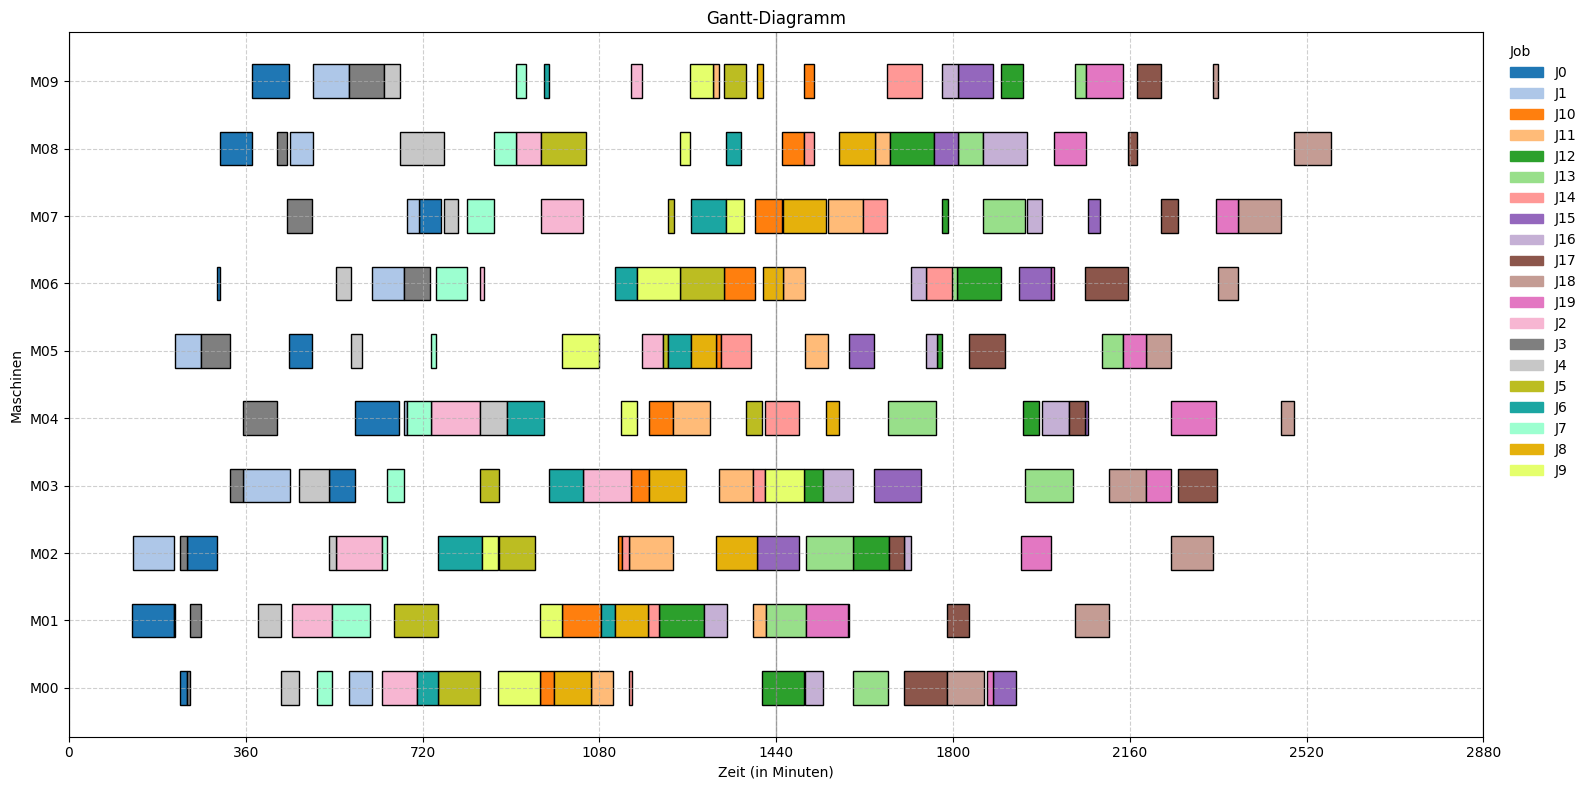

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [11]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


### Simulation

In [12]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J0 started on M01
[Day 1 00:00:00] Job J1 started on M02
[Day 1 00:00:00] Job J10 started on M00
[Day 1 00:36:41] Job J10 finished on M00 (after 36 minutes 41 seconds)
[Day 1 00:36:41] Job J11 started on M00
[Day 1 01:12:53] Job J11 finished on M00 (after 36 minutes 12 seconds)
[Day 1 01:12:53] Job J6 started on M00
[Day 1 01:28:18] Job J1 finished on M02 (after 88 minutes 19 seconds)
[Day 1 01:28:18] Job J14 started on M02
[Day 1 01:29:58] Job J0 finished on M01 (after 89 minutes 59 seconds)
[Day 1 01:29:58] Job J12 started on M01
[Day 1 01:42:30] Job J14 finished on M02 (after 14 minutes 11 seconds)
[Day 1 01:42:30] Job J15 started on M02
[Day 1 01:47:07] Job J6 finished on M00 (after 34 minutes 14 seconds)
[Day 1 01:47:07] Job J7 started on M00
[Day 1 02:17:09] Job J7 finished on M00 (after 30 minutes 01 second)
[Day 1 02:17:09] Job J8 started on M00
[Day 1 02:52:01] Job J12 finished on M01 (after 82 minutes 03 seconds)
[Day 1 02:52:01] Job J13 started on M01
[D

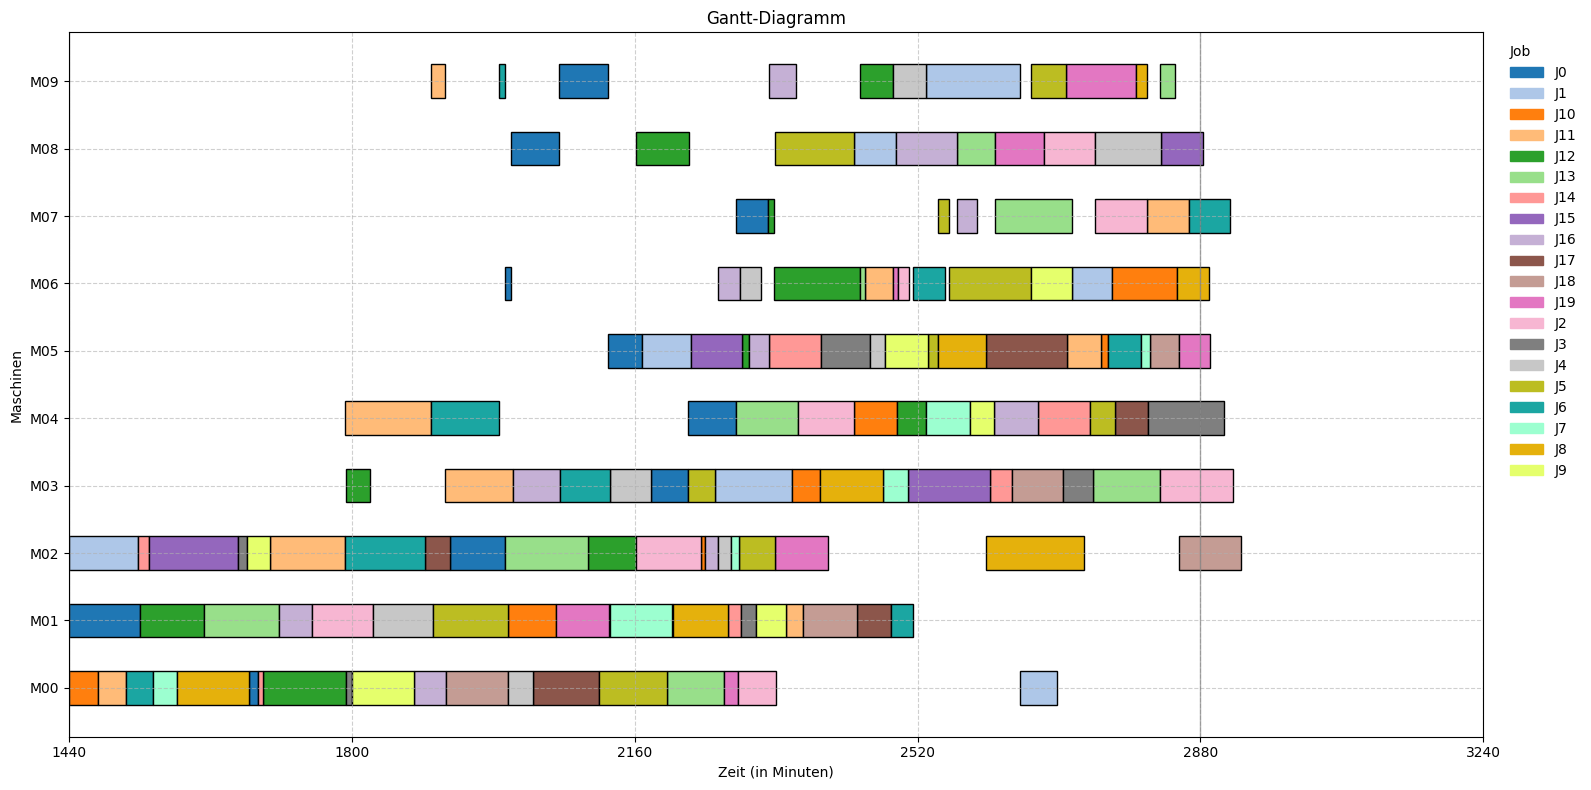

In [13]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine")
else:
    print(f"Nothing executed on day {day_numb}")

In [14]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Operation,Machine,Processing Time,Routing_ID,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J1,8,M04,6,5,130,1440,1104.0,682.0,688.0,0.0
1,J1,9,M07,25,5,130,1440,1104.0,688.0,713.0,0.0
2,J10,7,M07,56,0,922,1440,1697.0,1396.0,1452.0,0.0
3,J10,8,M08,44,0,922,1440,1697.0,1452.0,1496.0,0.0
4,J10,9,M09,21,0,922,1440,1697.0,1496.0,1517.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
44,J8,9,M08,74,8,526,1440,1698.0,1568.0,1642.0,0.0
45,J9,6,M08,19,7,535,1440,1593.0,1245.0,1264.0,0.0
46,J9,7,M09,48,7,535,1440,1593.0,1264.0,1312.0,0.0
47,J9,8,M07,36,7,535,1440,1593.0,1338.0,1374.0,0.0


#### Export

In [15]:
data_path = get_path("data", "tardiness")

In [16]:
df_jssp.to_csv(data_path / "02LP_all_jssp.csv", index = False)
df_jobs_times.to_csv(data_path / "02LP_all_times.csv", index = False)

In [17]:
df_schedule.to_csv(data_path / "02LP_init_schedule.csv", index = False)
df_execution.to_csv(data_path / "02LP_execution.csv", index = False)
df_plan_undone.to_csv(data_path / "02LP_init_undone.csv", index = False)